In [1]:
import wetter_api as wt
import waldbrand
import model_eval as me
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
import logging
import pandas as pd
import common_paths
import seaborn as sb
import plotly.express as pl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

In [2]:
parameter_list = [
    wt.DwdObservationParameter.MONTHLY.PRECIPITATION_HEIGHT,
    wt.DwdObservationParameter.MONTHLY.CLIMATE_SUMMARY.WIND_FORCE_BEAUFORT,
    wt.DwdObservationParameter.MONTHLY.TEMPERATURE_AIR_MAX_200,
]
# Dictionary with short names as keys and full names as values
shortname_to_state = {
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "BE": "Berlin",
    "BB": "Brandenburg",
    "HB": "Bremen",
    "HH": "Hamburg",
    "HE": "Hessen",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NW": "Nordrhein-Westfalen",
    "RP": "Rheinland-Pfalz",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "SH": "Schleswig-Holstein",
    "TH": "Thüringen",
}

# Example usage
shortname = "BB"
state = shortname_to_state.get(shortname)

In [3]:
data = me.prepare_data(parameter_list, state)
data

Year  Month station_id    pr   sfcWind  tasmax  nFires  area
21    1996      1      00164   0.2  3.384206  275.15     1.0   0.0
22    1996      1      00427   0.7  3.729582  277.45     1.0   0.0
23    1996      1      00650   1.0  2.276450  277.65     1.0   0.0
24    1996      1      00880   2.8  2.746595  280.65     1.0   0.0
25    1996      1      01001   1.4  3.770945  281.15     1.0   0.0
...    ...    ...        ...   ...       ...     ...     ...   ...
8370  2022     12      03158  37.2  2.897073  290.65     0.0   0.0
8371  2022     12      03376  40.7  2.897073  290.65     0.0   0.0
8373  2022     12      03987  58.8  4.409306  290.45     0.0   0.0
8377  2022     12      05825  45.4  2.897073  289.95     0.0   0.0
8380  2022     12      07389  40.7  2.840331  290.05     0.0   0.0

[6390 rows x 8 columns]

In [4]:
future_bb_weather = pd.read_csv(common_paths.DATA.joinpath("dwd/future_Brandenburg.csv"))
future_bb_weather.drop(columns=['Unnamed: 0', 'Bundesland'], inplace = True)
# adjust precipitation to same unit
future_bb_weather['pr'] = future_bb_weather['pr'] * 3600 * 24 * 30
future_bb_weather

pr     tasmax   sfcWind  Year  Month
0      51.580644  278.43063  4.900000  2024      1
1      54.774196  278.38547  4.761291  2024      1
2      63.967742  278.19840  4.422581  2024      1
3      47.709679  278.55966  4.416129  2024      1
4      47.709679  278.54030  4.367742  2024      1
...          ...        ...       ...   ...    ...
70390  41.612901  274.10160  4.516129  2054      1
70391  51.967742  273.57257  5.196774  2054      1
70392  51.967742  273.62740  5.316129  2054      1
70393  45.483872  273.60483  5.216129  2054      1
70394  47.419354  273.66290  5.241936  2054      1

[70395 rows x 5 columns]

In [5]:
#future_bb_weather = me.grid_means(future_brandenburg_weather)

In [6]:
print('means: \n' , data[['pr', 'sfcWind', 'tasmax']].mean())
print('\n variance: \n', data[['pr', 'sfcWind', 'tasmax']].var())
print('\n std: \n' , data[['pr', 'sfcWind', 'tasmax']].std())
print('\n min: \n', data[['pr', 'sfcWind', 'tasmax']].min())
print('\n max: \n', data[['pr', 'sfcWind', 'tasmax']].max())

means: 
 pr          46.103521
sfcWind      3.232686
tasmax     295.061628
dtype: float64

 variance: 
 pr         937.859930
sfcWind      0.828219
tasmax      75.838905
dtype: float64

 std: 
 pr         30.624499
sfcWind     0.910065
tasmax      8.708554
dtype: float64

 min: 
 pr           0.000000
sfcWind      0.510746
tasmax     274.250000
dtype: float64

 max: 
 pr         266.200000
sfcWind      7.768545
tasmax     312.350000
dtype: float64


In [7]:
print('means: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].mean())
print('\n variance: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].var())
print('\n std: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].std())
print('\n min: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].min())
print('\n max: \n' , future_bb_weather[['pr', 'sfcWind', 'tasmax']].max())

means: 
 pr          47.990091
sfcWind      3.670293
tasmax     287.263343
dtype: float64

 variance: 
 pr         738.434263
sfcWind      0.429837
tasmax      64.163249
dtype: float64

 std: 
 pr         27.174147
sfcWind     0.655619
tasmax      8.010197
dtype: float64

 min: 
 pr           0.387097
sfcWind      1.916129
tasmax     270.556460
dtype: float64

 max: 
 pr         257.599984
sfcWind      7.396774
tasmax     302.598400
dtype: float64


In [8]:
data

Year  Month station_id    pr   sfcWind  tasmax  nFires  area
21    1996      1      00164   0.2  3.384206  275.15     1.0   0.0
22    1996      1      00427   0.7  3.729582  277.45     1.0   0.0
23    1996      1      00650   1.0  2.276450  277.65     1.0   0.0
24    1996      1      00880   2.8  2.746595  280.65     1.0   0.0
25    1996      1      01001   1.4  3.770945  281.15     1.0   0.0
...    ...    ...        ...   ...       ...     ...     ...   ...
8370  2022     12      03158  37.2  2.897073  290.65     0.0   0.0
8371  2022     12      03376  40.7  2.897073  290.65     0.0   0.0
8373  2022     12      03987  58.8  4.409306  290.45     0.0   0.0
8377  2022     12      05825  45.4  2.897073  289.95     0.0   0.0
8380  2022     12      07389  40.7  2.840331  290.05     0.0   0.0

[6390 rows x 8 columns]

<Axes: >

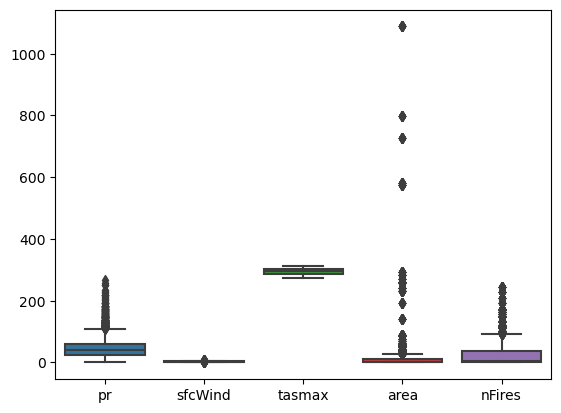

In [9]:
sb.boxplot(data[['pr', 'sfcWind', 'tasmax', 'area', 'nFires']])

<Axes: >

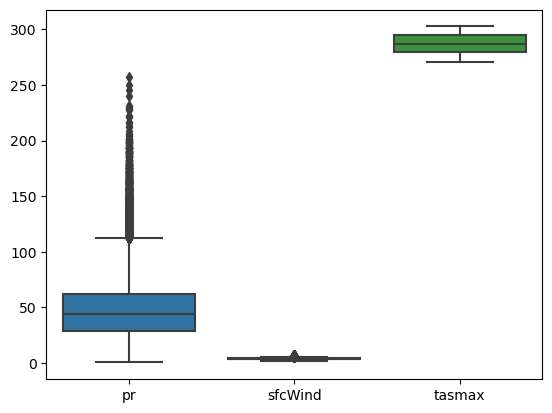

In [10]:
sb.boxplot(future_bb_weather[['pr', 'sfcWind', 'tasmax']])

In [11]:
test = me.station_means(data)
test_area = test.astype('float').groupby('Year')['area'].sum().reset_index()
test_nr  = test.astype('float').groupby('Year')['nFires'].sum().reset_index()

In [12]:
sum = pd.merge(test_area, test_nr, on=['Year'], how='outer')

In [13]:
sum

Year     area  nFires
0   1996.0   334.80   456.0
1   1997.0   186.90   608.0
2   1998.0    98.20   418.0
3   1999.0   153.20   485.0
4   2000.0   219.90   575.0
5   2001.0    35.90   258.0
6   2002.0    36.00   217.0
7   2003.0   616.90   718.0
8   2004.0   121.30   224.0
9   2005.0    56.60   185.0
10  2006.0   325.70   394.0
11  2007.0    53.30   223.0
12  2008.0   365.00   340.0
13  2009.0    91.70   250.0
14  2010.0   298.30   253.0
15  2011.0    46.20   225.0
16  2012.0    77.90   241.0
17  2013.0    49.10   167.0
18  2014.0    27.90   123.0
19  2015.0   328.40   332.0
20  2016.0   157.60   248.0
21  2017.0   285.40   141.0
22  2018.0  1674.09   512.0
23  2019.0  1388.63   429.0
24  2020.0   118.71   302.0
25  2021.0    41.89   168.0
26  2022.0  1425.66   523.0

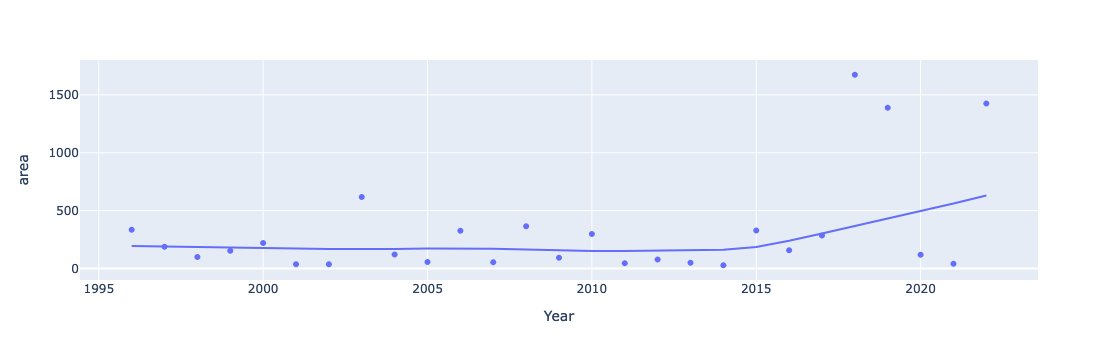

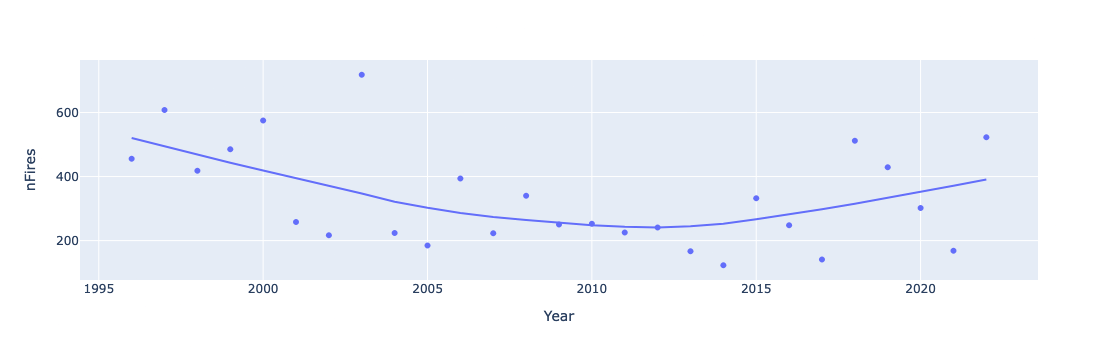

In [14]:
fig1 = pl.scatter(sum, x='Year', y='area', trendline="lowess")
fig2 = pl.scatter(sum, x='Year', y='nFires', trendline="lowess")
fig1.show()
fig2.show()

Text(0, 0.5, 'number of fires')

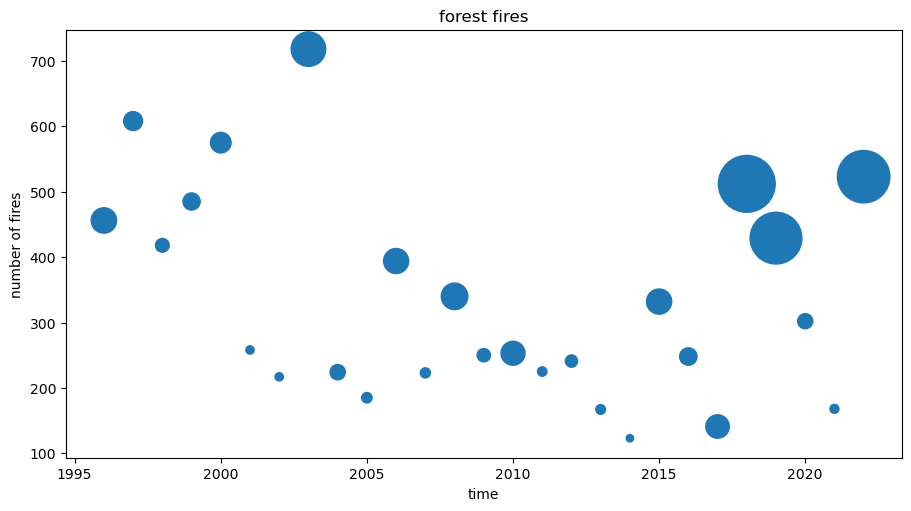

In [15]:
fig, ax = plt.subplots(figsize=(9, 5), layout='constrained')
ax.scatter('Year', 'nFires', s='area', data = sum)

ax.set_title('forest fires')
ax.set_xlabel('time')
ax.set_ylabel('number of fires')

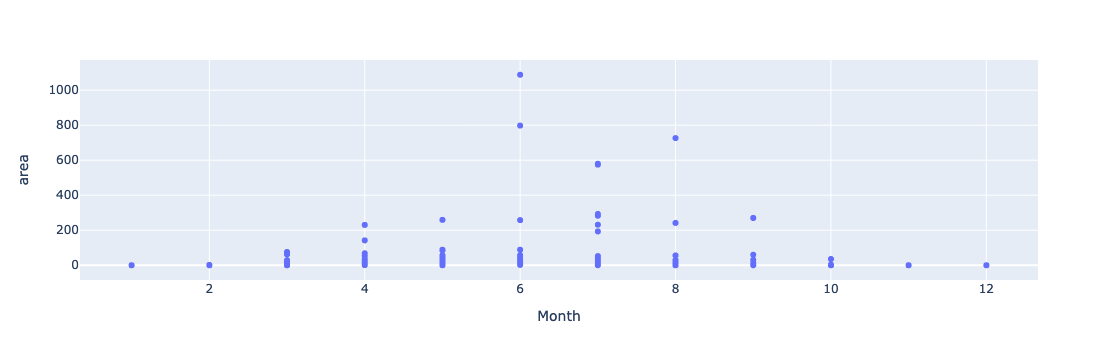

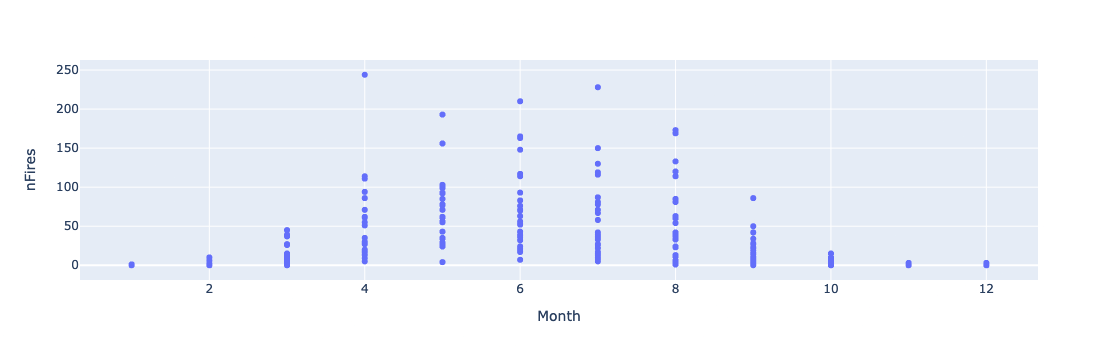

In [16]:
fig1 = pl.scatter(data, x='Month', y='area')
fig2 = pl.scatter(data, x='Month', y='nFires')
fig1.show()
fig2.show()

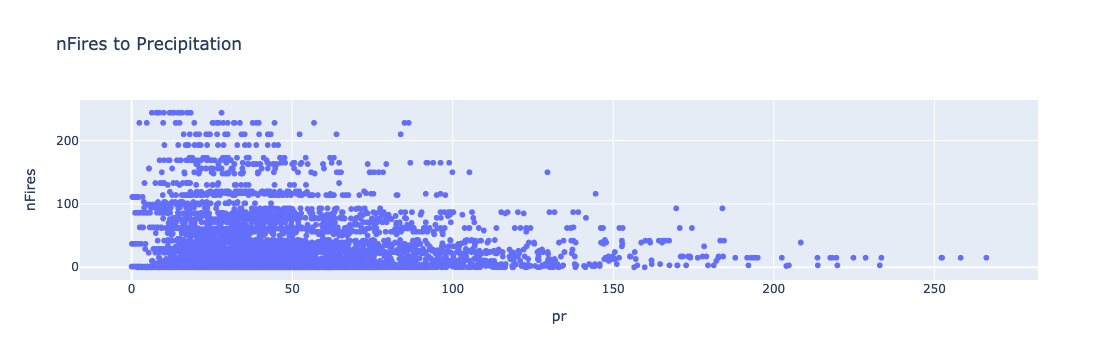

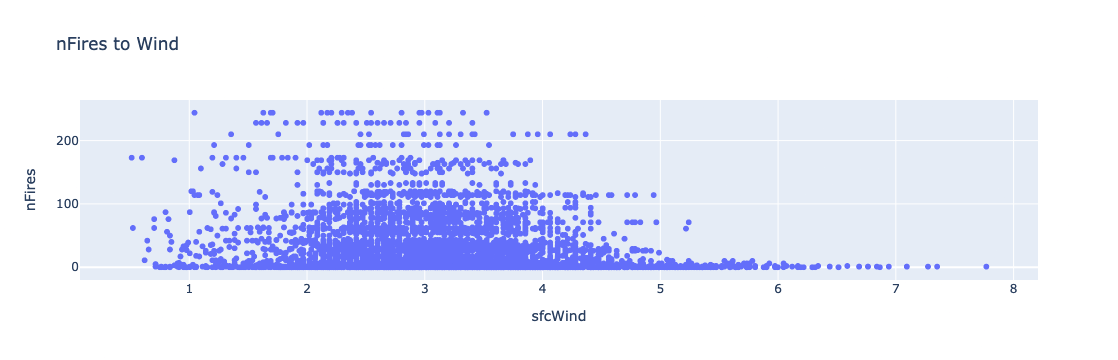

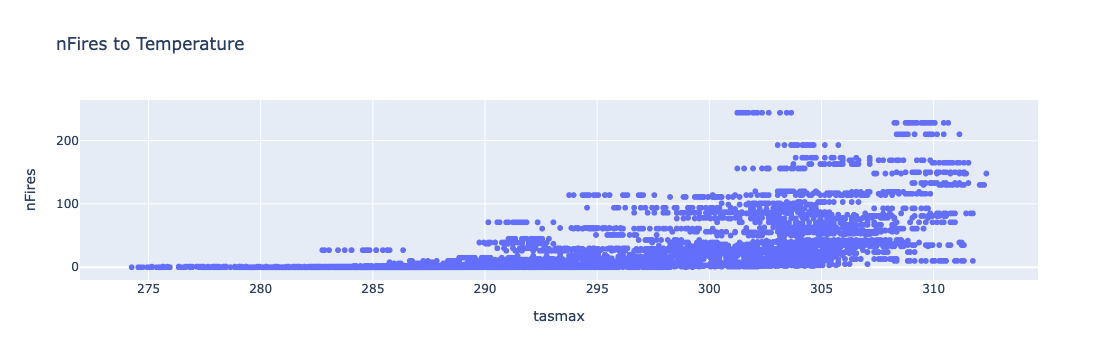

In [17]:
fig1 = pl.scatter(data, x = "pr", y = 'nFires', title='nFires to Precipitation')
fig2 = pl.scatter(data, x = "sfcWind", y = 'nFires', title='nFires to Wind')
fig3 = pl.scatter(data, x = "tasmax", y = 'nFires', title='nFires to Temperature')

fig1.show()
fig2.show()
fig3.show()

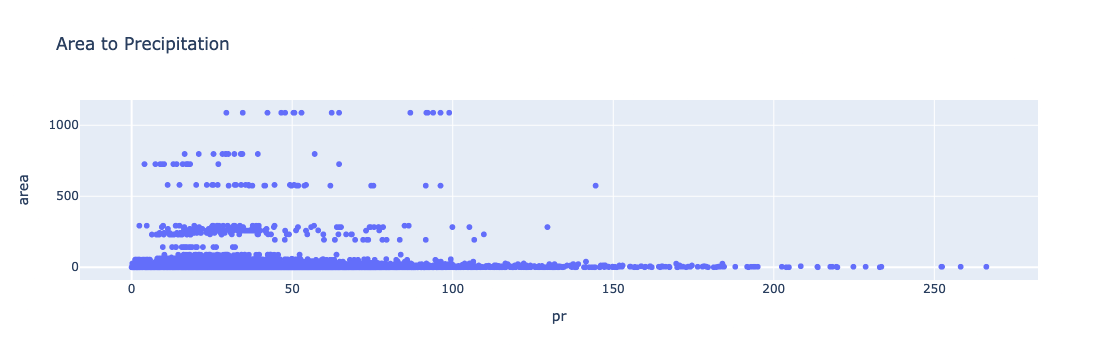

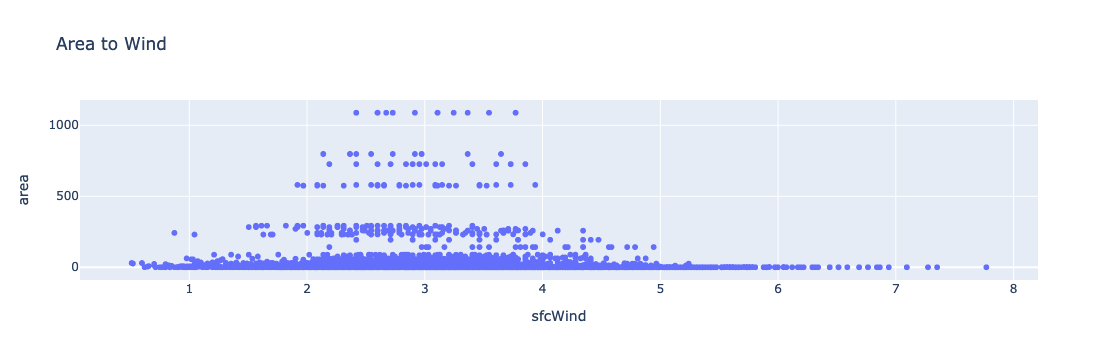

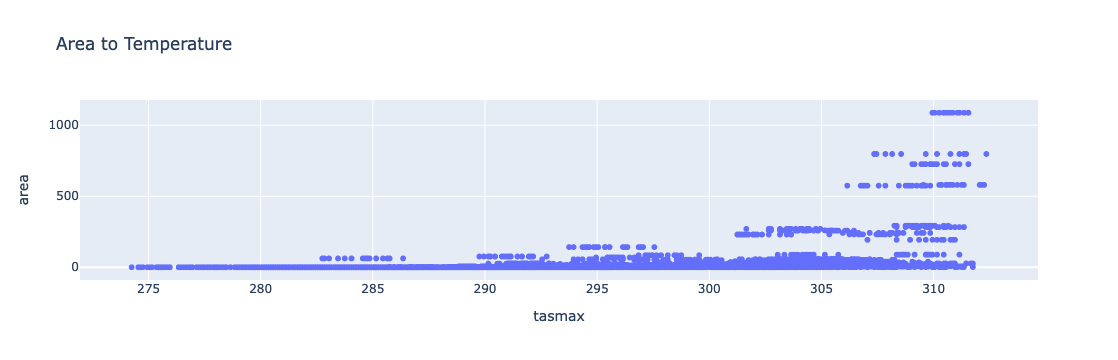

In [18]:
fig1 = pl.scatter(data, x = "pr", y = 'area', title='Area to Precipitation')
fig2 = pl.scatter(data, x = "sfcWind", y = 'area', title='Area to Wind')
fig3 = pl.scatter(data, x = "tasmax", y = 'area', title='Area to Temperature')

fig1.show()
fig2.show()
fig3.show()

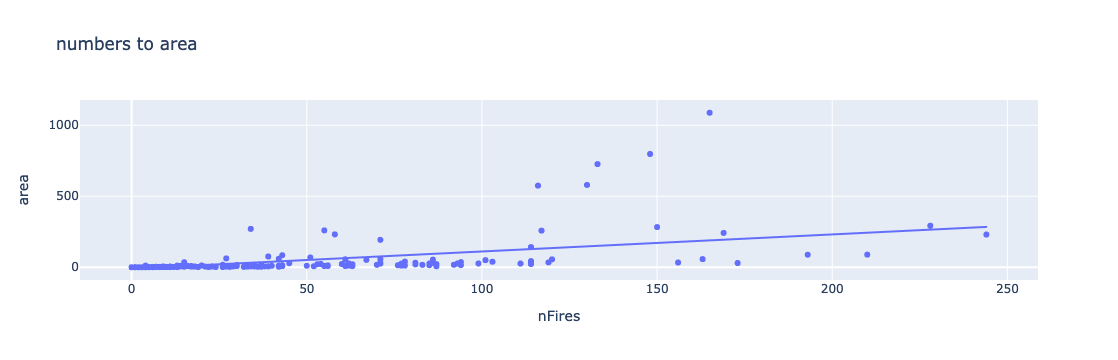

In [19]:
fig1 = pl.scatter(data, x = "nFires", y = 'area', trendline="ols", title='numbers to area')
fig1.show()

In [20]:
data['area'].unique()

array([0.00000e+00, 1.00000e-01, 1.70000e+00, 1.50000e+00, 2.00000e-01,
       3.00000e-01, 5.00000e-02, 6.21000e+01, 2.83000e+01, 1.23000e+01,
       6.00000e-01, 2.00000e+00, 7.57000e+01, 1.11000e+01, 1.14000e+01,
       4.00000e-01, 1.20000e+00, 7.40000e+00, 1.52000e+01, 7.20000e+00,
       8.00000e-01, 2.90000e+00, 5.04000e+00, 2.81000e+00, 7.00000e-02,
       5.40000e-01, 5.00000e-01, 3.41000e+00, 2.30300e+02, 2.54000e+01,
       6.90000e+00, 9.30000e+00, 8.90000e+00, 8.50000e+00, 1.04000e+01,
       1.42200e+02, 5.60000e+01, 2.32000e+01, 2.60000e+01, 6.20000e+00,
       5.35000e+01, 5.80000e+00, 6.30000e+00, 1.33000e+01, 3.10000e+00,
       6.00000e+00, 6.86000e+01, 1.64000e+01, 1.24600e+01, 8.54000e+00,
       3.65200e+01, 1.50600e+01, 5.83000e+00, 8.10000e+00, 2.57000e+01,
       3.32000e+01, 1.74000e+01, 8.84000e+01, 1.24000e+01, 2.40000e+00,
       4.98000e+01, 1.76000e+01, 5.50000e+00, 1.22000e+01, 2.67000e+01,
       9.10000e+00, 1.18000e+01, 9.00000e+00, 5.66000e+01, 2.594

<Axes: >

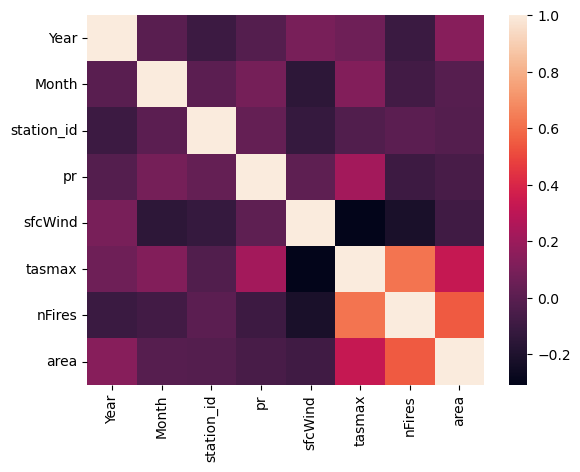

In [21]:
'''
Achtung hier lineare korrelationen -> hoch heißt korrelation ist stark aber niedrig kann andere art von korrelation sein
(BSP regen zu feuer)
'''
sb.heatmap(data.corr(method='pearson', numeric_only=False))

In [22]:
str_parameter_list = [str(param) for param in parameter_list]
dates = data[['Year', 'Month']]
feature_list = ["sfcWind", "pr", "tasmax"]

X_nr = data[feature_list]
y_nr = data["nFires"]

#X, y, dates = shuffle(X, y, dates, random_state=42)
X_train_nr, X_test_nr, y_train_nr, y_test_nr, dates_train, dates_test = train_test_split(X_nr, y_nr, dates, test_size=0.2, random_state=42)

In [23]:
#X_scaled_train_nr = RobustScaler().fit_transform(X_train_nr)
#X_scaled_test_nr = RobustScaler().fit_transform(X_test_nr)
X_scaled_train_nr = X_train_nr
X_scaled_test_nr = X_test_nr

In [24]:
from sklearn.model_selection import KFold
param_grid = {
    "n_estimators": [70, 80, 100],
    "max_depth": [3, 5, 6],  # Smaller range for max depth
    "min_samples_leaf": [2, 3, 5],
    "min_samples_split": [5, 7, 8]
}
gbr = GradientBoostingRegressor()
cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(
    estimator=gbr, param_grid=param_grid, cv=cv, scoring="neg_mean_squared_error"
)
#searching for the right parameters using random Forest on a 5-fold Cross Validation (cv) and the nmse
nr_grid = grid_search.fit(X_scaled_train_nr, y_train_nr)

# saving best parameters and model
nr_best_params = grid_search.best_params_
nr_best_model = grid_search.best_estimator_
print(nr_best_params)
print(nr_best_model)

{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 80}
GradientBoostingRegressor(min_samples_leaf=3, min_samples_split=8,
                          n_estimators=80)


In [25]:
#predict 'Anzahl Waldbrände' with the model
y_pred_nr = nr_best_model.predict(X_scaled_test_nr)


mse = mean_squared_error(y_test_nr, y_pred_nr)
r2 = r2_score(y_test_nr, y_pred_nr)
mae = mean_absolute_error(y_test_nr, y_pred_nr)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")
#print(y_pred_nr)

MSE: 790.5037771510008
R2 Score: 0.573481649474942
MAE: 16.029675528122077


In [26]:
feature_list = ["sfcWind", "pr", "tasmax"]

X_area = data[feature_list]
y_area = data['area']

X_train_area, X_test_area, y_train_area, y_test_area = train_test_split(X_area, y_area, test_size=0.2, random_state=42)

In [27]:
X_scaled_train_area = RobustScaler().fit_transform(X_train_area)
X_scaled_test_area = RobustScaler().fit_transform(X_test_area)

In [28]:
param_grid = {
    "n_estimators": [65, 75, 85],
    "max_depth": [3, 5, 6],  # Smaller range for max depth
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [6, 7, 8]
}
gbr = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=gbr, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)
#searching for the right parameters using random Forest on a 5-fold Cross Validation (cv) and the nmse
area_grid = grid_search.fit(X_scaled_train_area, y_train_area)

# saving best parameters and model
area_best_params = grid_search.best_params_
area_best_model = grid_search.best_estimator_
print(area_best_params)
print(area_best_model)

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 65}
GradientBoostingRegressor(min_samples_split=8, n_estimators=65)


In [29]:
y_pred_area = area_best_model.predict(X_scaled_test_area)


mse = mean_squared_error(y_test_area, y_pred_area)
r2 = r2_score(y_test_area, y_pred_area)
mae = mean_absolute_error(y_test_area, y_pred_area)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")

MSE: 5618.020339011231
R2 Score: 0.19573404004023942
MAE: 25.859645118246476


In [30]:
X_scaled_train_nr

sfcWind     pr  tasmax
7956  3.344314   24.3  288.05
2964  3.205940   84.7  300.35
4509  3.525064   61.8  306.25
6945  3.205940   14.4  296.15
5739  2.709396  128.3  294.45
...        ...    ...     ...
4970  4.001140   46.9  305.35
6780  2.035749   34.2  294.55
6839  4.214318   85.0  295.85
7093  2.346853   35.4  287.35
1075  2.954189   20.4  284.55

[5112 rows x 3 columns]

In [31]:
#future_scaled = RobustScaler().fit_transform(future_bb_weather[feature_list])

In [32]:
future_bb_weather[feature_list]

sfcWind         pr     tasmax
0      4.900000  51.580644  278.43063
1      4.761291  54.774196  278.38547
2      4.422581  63.967742  278.19840
3      4.416129  47.709679  278.55966
4      4.367742  47.709679  278.54030
...         ...        ...        ...
70390  4.516129  41.612901  274.10160
70391  5.196774  51.967742  273.57257
70392  5.316129  51.967742  273.62740
70393  5.216129  45.483872  273.60483
70394  5.241936  47.419354  273.66290

[70395 rows x 3 columns]

In [33]:
nr_predictions = nr_best_model.predict(future_bb_weather[feature_list])
area_predictions = area_best_model.predict(future_bb_weather[feature_list])
nr_predictions

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GradientBoostingRegressor was fitted without feature names



array([0.9130962 , 0.82160188, 0.55995965, ..., 0.9130962 , 1.26841976,
       1.0285553 ])

In [34]:
final_predictions = pd.DataFrame({'Year': future_bb_weather['Year'], 'Month': future_bb_weather['Month'], 'tasmax': future_bb_weather['tasmax'], 'sfcWind': future_bb_weather['sfcWind'],'pr': future_bb_weather['pr'], 'area_predictions': area_predictions, 'nr_predictions': nr_predictions})

In [35]:
print(final_predictions)

       Year  Month     tasmax   sfcWind         pr  area_predictions  \
0      2024      1  278.43063  4.900000  51.580644        276.464071   
1      2024      1  278.38547  4.761291  54.774196        276.464071   
2      2024      1  278.19840  4.422581  63.967742        276.464071   
3      2024      1  278.55966  4.416129  47.709679        276.464071   
4      2024      1  278.54030  4.367742  47.709679        276.464071   
...     ...    ...        ...       ...        ...               ...   
70390  2054      1  274.10160  4.516129  41.612901        276.464071   
70391  2054      1  273.57257  5.196774  51.967742        276.464071   
70392  2054      1  273.62740  5.316129  51.967742        276.464071   
70393  2054      1  273.60483  5.216129  45.483872        276.464071   
70394  2054      1  273.66290  5.241936  47.419354        276.464071   

       nr_predictions  
0            0.913096  
1            0.821602  
2            0.559960  
3            0.832190  
4            0.

In [36]:
area_predictions

array([276.46407108, 276.46407108, 276.46407108, ..., 276.46407108,
       276.46407108, 276.46407108])

In [37]:
final_predictions

Year  Month     tasmax   sfcWind         pr  area_predictions  \
0      2024      1  278.43063  4.900000  51.580644        276.464071   
1      2024      1  278.38547  4.761291  54.774196        276.464071   
2      2024      1  278.19840  4.422581  63.967742        276.464071   
3      2024      1  278.55966  4.416129  47.709679        276.464071   
4      2024      1  278.54030  4.367742  47.709679        276.464071   
...     ...    ...        ...       ...        ...               ...   
70390  2054      1  274.10160  4.516129  41.612901        276.464071   
70391  2054      1  273.57257  5.196774  51.967742        276.464071   
70392  2054      1  273.62740  5.316129  51.967742        276.464071   
70393  2054      1  273.60483  5.216129  45.483872        276.464071   
70394  2054      1  273.66290  5.241936  47.419354        276.464071   

       nr_predictions  
0            0.913096  
1            0.821602  
2            0.559960  
3            0.832190  
4            0.832190  
...               ...  
70390        1.268420  
70391        0.913096  
70392        0.913096  
70393        1.268420  
70394        1.028555  

[70395 rows x 7 columns]

In [148]:
final_predictions.to_csv(common_paths.DATA.joinpath("dwd/final_predictions.csv"))

In [149]:
final_predictions[['nr_predictions', 'area_predictions']].describe()

nr_predictions  area_predictions
count    70395.000000      70395.000000
mean         7.121642        276.497671
std         10.255206          3.291326
min         -8.996922        276.464071
25%          0.917849        276.464071
50%          2.515058        276.464071
75%         10.905997        276.464071
max        105.620833        766.496611

In [150]:
data[['area', 'nFires']].describe()

area       nFires
count  6390.000000  6390.000000
mean     24.324540    27.749139
std      94.381655    43.159510
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.770000     6.000000
75%      10.400000    37.000000
max    1088.260000   244.000000